In [58]:
import gc
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# if using google colab - set up path properly
if 'google.colab' in str(get_ipython()):
    !pip install mido
    !pip install pretty_midi

    from google.colab import drive
    drive.mount('/content/drive/')

    import sys
    cwd = '/content/drive/My Drive/school/stat4984/final_proj/'
    sys.path.append(cwd)

else:
    cwd = os.getcwd()+'/'

from midi_ndarrays import *
from midi_utils import *

# set up directories
midi_data_dir = cwd+'midi_data/'
csv_data_dir  = cwd+'csv_data/'

if not os.path.exists(midi_data_dir):
    os.makedirs(midi_data_dir)

if not os.path.exists(midi_data_dir):
    os.makedirs(csv_data_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 5.6 MB 5.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=d1993e3332260e73304d0a91b46d170d91591b390dcccd392c033ac51a564830
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Utility Functions



In [2]:
def dir_idx(dir_name, n):
    """
    return the name of the nth file in a directory
    """
    
    return dir_name+os.listdir(dir_name)[n]

In [3]:
def print_GPU_memory():
    max = torch.cuda.max_memory_allocated()
    
    print(0 if max == 0 else torch.cuda.memory_allocated() / max)

In [4]:
def free_GPU():
    gc.collect()

    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()

# Data Preprocessing

In [5]:
# only download midis if the batch dir doesn't exist and midi dir is empty
if len(os.listdir(midi_data_dir)) == 0 and len(os.listdir(csv_data_dir)) == 0:
    import mido
    download_midis(midi_data_dir)

def load_array(midi_filename):
    """
    return midi_filename as a ndarray with start and end tokens
    Replace all notes with 1 - played, or 0 - not played
    """
    midi_tracks = mido.MidiFile(midi_filename, clip=True)
    midi_array = mid2array(midi_tracks)
    
    # set all values to 1 or 0
    midi_array = np.where(midi_array != 0, 1, 0).astype('uint8')
    
    # add padding and encode start token (first column)
    # and end token (last column)
    midi_array = np.pad(midi_array, 1)
    midi_array[0, 0]   = 1
    midi_array[-1, -1] = 1
    
    return midi_array

# if there aren't any csv files, convert all midis arrays and save in csv
if len(os.listdir(csv_data_dir)) == 0:
    for i in range(len(os.listdir(midi_data_dir))):
        midi_filename = dir_idx(midi_data_dir, i)
        midi_array = load_array(midi_filename)
        np.savetxt(midi_filename[:-4]+".csv", midi_array, fmt="%d", delimiter=",")

# The Model

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_p):
        super().__init__()
        
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        
        self.dropout   = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn       = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        # input dimension [1, 90]
        embedding = self.dropout(self.embedding(x))
        _, (h, c) = self.rnn(embedding)
        return h, c

In [7]:
class DecoderRNN(nn.Module):
    # TODO remove output_size
    def __init__(self, input_size, hidden_size, output_size, 
                num_layers, dropout_p):
    
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        self.dropout = nn.Dropout(dropout_p)
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden, cell):
        x = x.float()
        x = x.unsqueeze(0).unsqueeze(-1)
        
        # x shape: [1, 90, 1]
        outputs, (hidden, cell) = self.rnn(x, (hidden, cell))
        predictions = self.fc(outputs.squeeze(0))

        # sigmoid because we're predicting multiple notes
        predictions = torch.sigmoid(predictions.squeeze(1))

        return predictions, hidden, cell

In [109]:
class Seq2Seq(nn.Module):
    """
    Encapsulates the encoder and decoder. Pass a song matrix to the forward method, and it
    will encode it, then output the decoder's prediction of it
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
  
    def forward(self, x, teacher_forcing_ratio=0.5):
        """
        pre: x is the song on host not device - the gpu runs out of memory
             with the whole song
        """
        # x: the song with shape [len, 90]

        #tensor to store decoder outputs
        outputs = torch.zeros(x.shape)
        
        # encoder input song
        len_song = x.shape[0]

        # pass the song to the encoder
        h,c = self.encoder(x.to(device))
        
        #first input to the decoder is the <sos> tokens
        input = x[0,:].to(device)

        # decode the length of the song and return prediction
        for t in range(1, len_song):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, h, c = self.decoder(input, h, c)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output.to("cpu")
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = x[t,:].to(device) if teacher_force else output

        return outputs

    def generate_song(self, max_length):
        """
        Generate a song based on the parameters of the encoder and decoder
        Pre: encoder and decoder should be optimized
        Return: The song as an song_length x 88 size numpy array
        """

        num_notes = self.encoder.input_size

        #song_matrix = torch.zeros(max_length, num_notes, dtype=torch.int)

        song_matrix = np.zeros((max_length, num_notes), dtype='int')
        
        # encode start token
        input = torch.zeros(1, num_notes, dtype=torch.int)
        input[0] = 1

        # initial state is based on encoding the start token
        input = input.to(device)

        h, c = self.encoder(input)

        input = input.squeeze(0)

        # Predict the notes of this song following inputting the start token
        for t in range(1, max_length):
            # input is the predicted set of notes, and the input to the next
            # prediction
            input, h, c = self.decoder(input, h, c)

            pred = input.to("cpu").detach().numpy()
            
            # if no predicted values are greater than 0.5,
            # update the next input to the three highest values in the array
            if np.where(pred > 0.6)[0].size == 0:
                highest_indices = pred.argsort()[-3:][::-1]
                row = np.zeros_like(pred)
                row[highest_indices] = 1

            else:
                row = np.where(pred > 0.6, 1, 0).astype('int')
            
            song_matrix[t] = row

            # if end token is predicted: end
            if row[-1] > 0.8 and t >= 500:
                break

            input = torch.Tensor(row).to(device)

        # the song generated until the end token (or max_length)
        song_matrix = song_matrix[:t+1,:]

        # trim outer padding for start and end tokens
        return song_matrix[1:-1, 1:-1]

# Train

In [9]:
drop_p = 0.5

# data has 88 columns for each piano note, plus two for start and end tokens
midi_dim = 90

# model hyperparameters
hidden_size = 64
num_layers = 2

# training hyperparemeters
num_epochs = 1
num_songs  = 10

# number of tempos of each song to pass at a time
batch_size = 5_000

save_model  = True
load_model  = True
train_model = True
model_filename = "model.pt"

In [110]:
encoder = EncoderRNN(midi_dim, hidden_size, num_layers, drop_p)
decoder = DecoderRNN(1, hidden_size, 1, num_layers, drop_p)
model = Seq2Seq(encoder, decoder).to(device)

# model = Seq2Seq(encoder, decoder)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [12]:
num_songs = min(num_songs, len(os.listdir(csv_data_dir)))

def train(model, num_songs):
    """
    Pass num_songs to the model and optimize at each
    """
    model.train()

    epoch_loss = 0

    for i in range(num_songs):
        optimizer.zero_grad()

        # load song as numpy array
        midi_tensor = np.genfromtxt(dir_idx(csv_data_dir, i), delimiter=',', dtype='int')
        
        # convert to tensor
        midi_tensor = torch.IntTensor(midi_tensor)
        len_song = midi_tensor.shape[0]

        # number of batches this song can be split into
        num_batches = math.ceil(len_song / batch_size)

        # decode prediction
        for i in range(num_batches):
            # last batch
            if i == num_batches-1:
                batch = midi_tensor[i*batch_size:,:]
            
            else:
                batch = midi_tensor[i*batch_size:(i+1)*batch_size,:]

            batch_pred = model(batch.to(device))

            # optimize
            loss = criterion(batch_pred, batch.float())

            loss.backward()
            optimizer.step()

# load the model
if load_model and not save_model and model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename))

In [13]:
# train the model
if train_model:
    for epoch in range(num_epochs):
        train(model, num_songs)

    # save the model
    if save_model:
        torch.save(model.state_dict(), cwd+model_filename)

In [111]:
arr2 = model.generate_song(5000)

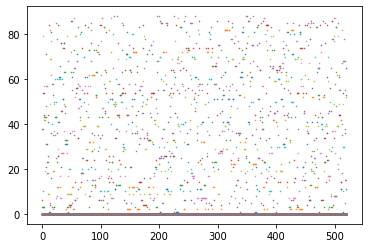

In [117]:
visualize_midi_array(arr2)
plt.show()

In [120]:
mid.save("generated2.mid")

In [121]:
play_midi("generated2.mid")